# Assignment 4: Dimensionality Reduction and Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from models import PCA_Scratch, Autoencoder_Scratch, KMeans_Scratch, GMM_Scratch
from metrics import *
import time

# Ensure reproducibility
np.random.seed(42)

# Graphing settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded. Ready for implementation.")

Libraries loaded. Ready for implementation.


## Data Loading & Preprocessing
Data Normailzation

In [2]:
def load_and_preprocess():
    # Load dataset
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    
    # Custom Standardization (Z-score normalization)
    # Mean centering and variance scaling
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Handle zero standard deviation to avoid division by zero
    std[std == 0] = 1.0
    
    X_scaled = (X - mean) / std
    
    print(f"Dataset loaded: {X_scaled.shape}")
    return X_scaled, y, feature_names

X, y_true, feat_names = load_and_preprocess()

Dataset loaded: (569, 30)


## Experiments

In [ ]:
# --- Experiment Runner Helper ---
results_buffer = []

def run_evaluation(exp_name, model_name, X_data, labels_pred, y_true, 
                   time_taken, reconstruction_error=None, extra_params={}):
    """Computes all metrics and stores them."""
    
    # Internal Metrics
    if len(np.unique(labels_pred)) > 1:
        sil = silhouette_score_scratch(X_data, labels_pred)
        dbi = davies_bouldin_index(X_data, labels_pred)
        ch_score = calinski_harabasz_scratch(X_data, labels_pred)
        
    else:
        sil, dbi, ch_score = -1, -1, -1 # Invalid for single cluster

    # External Metrics
    ari = adjusted_rand_index_scratch(y_true, labels_pred)
    nmi = normalized_mutual_info_scratch(y_true, labels_pred)
    pur = purity_score(y_true, labels_pred)
    res = {
        'Experiment': exp_name,
        'Model': model_name,
        'Silhouette': sil,
        'DBI': dbi,
        'Calinski-Harabasz': ch_score,
        'ARI': ari,
        'NMI': nmi,
        'Purity': pur,
        'Time(s)': time_taken,
        'Rec_Error': reconstruction_error
    }
    res.update(extra_params)
    results_buffer.append(res)
    return res


def run_statistical_experiment(exp_name, model_class, data, y_true, n_runs=5, model_type='kmeans', **model_params):
    """
    Runs a specific model configuration 5 times and returns the mean/std of metrics.
    """
    ari_scores = []
    sil_scores = []
    pur_scores = []
    ch_scores = []
    times = []
    
    for i in range(n_runs):
        start_time = time.time()
        
        # Initialize and fit model with different seeds
        if model_type == 'kmeans':
            model = model_class(**model_params)
            model.fit(data)
            labels = model.labels
        else: # GMM
            model = model_class(**model_params)
            model.fit(data)
            labels = model.predict(data)
            
        end_time = time.time()
        
        # Calculate metrics for this run
        ari_scores.append(adjusted_rand_index_scratch(y_true, labels))
        sil_scores.append(silhouette_score_scratch(data, labels))
        pur_scores.append(purity_score(y_true, labels))
        ch_scores.append(calinski_harabasz_scratch(data, labels))
        times.append(end_time - start_time)

    # Compile the average results for the summary table
    res = {
        'Experiment': exp_name,
        'ARI_mean': np.mean(ari_scores),
        'ARI_std': np.std(ari_scores),
        'Silhouette_mean': np.mean(sil_scores),
        'Purity_mean': np.mean(pur_scores),
        'CH_mean': np.mean(ch_scores),
        'Avg_Time': np.mean(times)
    }
    results_buffer.append(res)
    return labels # Returns labels from the last run for plotting

### Experiment 1: K-Means on Original Data

--- Starting Experiment 1 ---


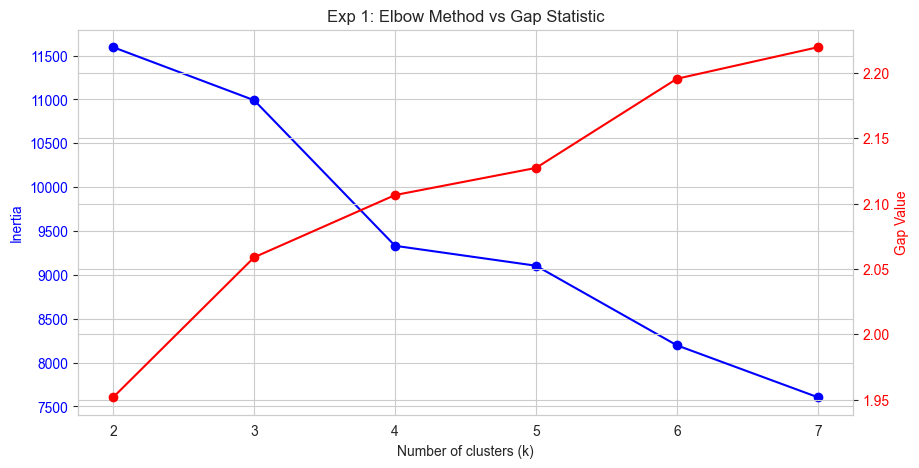

Optimal k based on Silhouette: 2


In [29]:
print("--- Starting Experiment 1 ---")

# 1. Find optimal K (Elbow/Silhouette)
k_range = [2, 3, 4, 5, 6, 7]
best_k_sil = 2
best_sil_val = -1

inertias_ran = []
inertias_kpp = []

gaps = []

for k in k_range:
    # Measure Random Init
    start_time = time.time()

    km_rnd = KMeans_Scratch(n_clusters=k, init='random', max_iter=300)
    km_rnd.fit(X)
    inertias_ran.append(km_rnd.inertia_)
    time_rnd = time.time() - start_time
    
    run_evaluation(f"Exp1_FindK_Random", "KMeans", X, km_rnd.labels, y_true, time_rnd, 
                   extra_params={'k': k, 'init': 'random', 'Inertia': km_rnd.inertia_})

    # Measure K-Means++ Init
    start_time = time.time()
    km_pp = KMeans_Scratch(n_clusters=k, init='k-means++', max_iter=300)
    km_pp.fit(X)
    inertias_kpp.append(km_pp.inertia_)

    time_pp = time.time() - start_time
    
    metrics = run_evaluation(f"Exp1_FindK_PP", "KMeans", X, km_pp.labels, y_true, time_pp, 
                             extra_params={'k': k, 'init': 'pp', 'Inertia': km_pp.inertia_})
    
    # Track best k
    if metrics['Silhouette'] > best_sil_val:
        best_sil_val = metrics['Silhouette']
        best_k_sil = k

gaps, gap_errors = calculate_gap_statistic(X, k_range, KMeans_Scratch)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Elbow Curve (Inertia)
ax1.plot(k_range, inertias_kpp, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Gap Statistic Curve
ax2 = ax1.twinx()
ax2.plot(k_range, gaps, 'ro-', label='Gap Statistic')
ax2.set_ylabel('Gap Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Exp 1: Elbow Method vs Gap Statistic')
plt.show()


print(f"Optimal k based on Silhouette: {best_k_sil}")
# Note: For Breast Cancer, ground truth is 2. We will use k=2 for subsequent clustering experiments.
GLOBAL_K = 2

The inertia curve (Elbow Method) shows a clear reduction in improvement after **k = 2**, indicating diminishing returns when adding more clusters. The Gap Statistic increases with k but does not exhibit a strong gain beyond **k = 2**, suggesting limited additional structure captured by higher k values. 

Overall, both methods point to **k = 2** as a reasonable and well-justified choice, which is consistent with the known ground truth of the dataset.

### Experiment 2: GMM on Original Data

In [30]:
print("--- Starting Experiment 2: GMM Analysis ---")

cov_types = ['full', 'tied', 'diag', 'spherical']
comp_range = [2, 3, 4, 5, 6]

model_selection_results = []
convergence_histories = {} 

for cov in cov_types:
    for n_comp in comp_range:
        # We run this once for selection; the statistical 5-run loop happens later
        gmm = GMM_Scratch(n_components=n_comp, cov_type=cov, max_iter=100)
        try:
            start_time = time.time()
            gmm.fit(X)
            labels = gmm.predict(X)
            elapsed = time.time() - start_time
            
            bic, aic = gmm.get_bic_aic(X)
            
            # Store for plotting
            model_selection_results.append({
                'cov': cov, 'k': n_comp, 'BIC': bic, 'AIC': aic
            })
            
            # Save convergence history for the standard K=2 case to compare covariance types
            if n_comp == 2:
                convergence_histories[cov] = gmm.log_likelihood_history

            # Run evaluation for the final table
            run_evaluation(f"Exp2_GMM_{cov}_k{n_comp}", "GMM", X, labels, y_true, elapsed, 
                           extra_params={'n_comp': n_comp, 'cov_type': cov, 'BIC': bic, 'AIC': aic})
            
        except Exception as e:
            print(f"GMM {cov} k={n_comp} failed: {e}")

# Selection of global best based on domain (Breast Cancer = 2 classes)
GLOBAL_GMM_COMPONENTS = 2
GLOBAL_COV_TYPE = 'full'

--- Starting Experiment 2: GMM Analysis ---


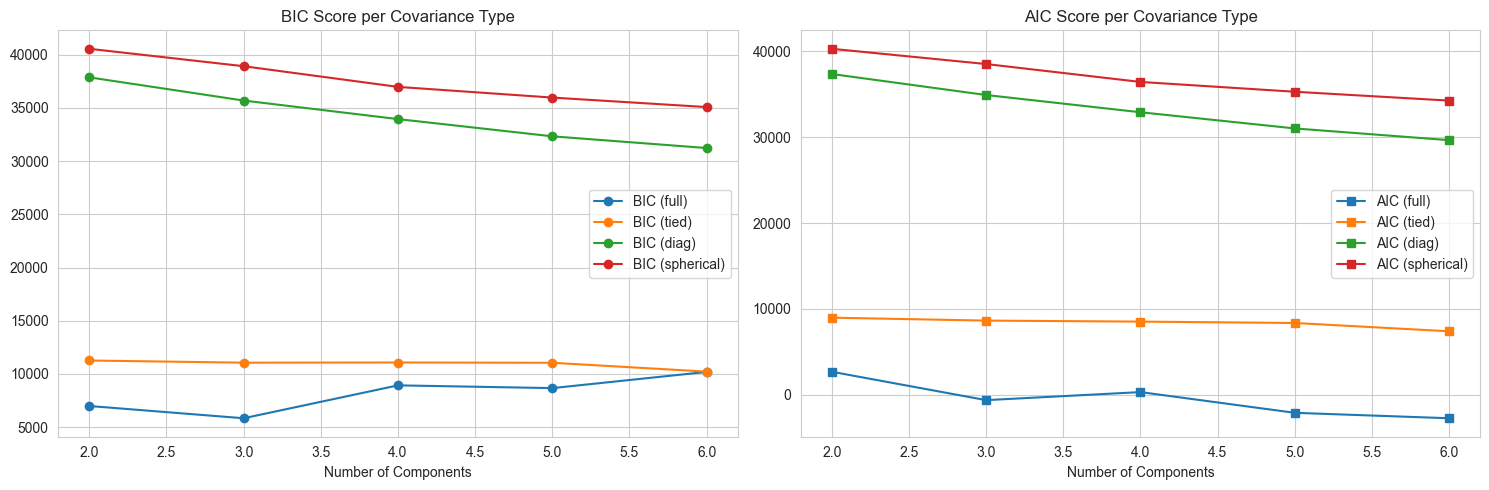

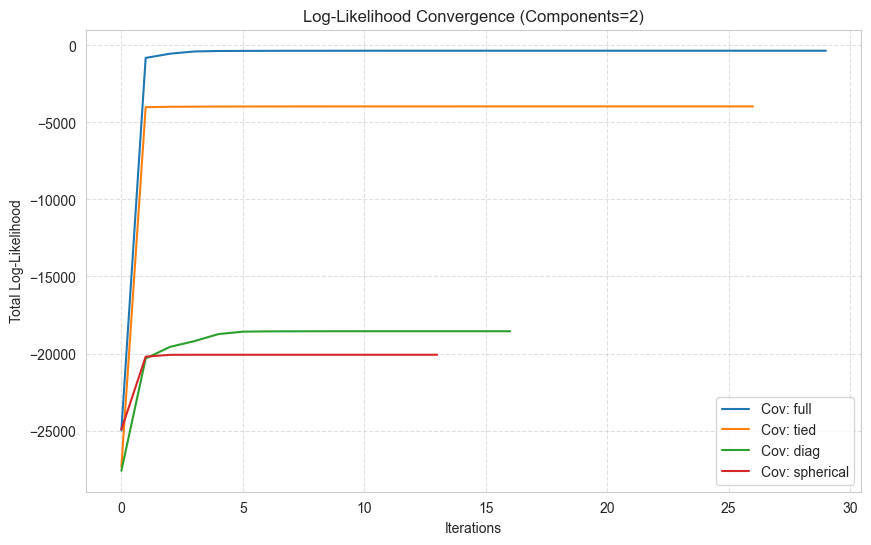

In [32]:
df_selection = pd.DataFrame(model_selection_results)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot BIC
for cov in cov_types:
    subset = df_selection[df_selection['cov'] == cov]
    ax[0].plot(subset['k'], subset['BIC'], marker='o', label=f'BIC ({cov})')
ax[0].set_title('BIC Score per Covariance Type')
ax[0].set_xlabel('Number of Components')
ax[0].legend()

# Plot AIC
for cov in cov_types:
    subset = df_selection[df_selection['cov'] == cov]
    ax[1].plot(subset['k'], subset['AIC'], marker='s', label=f'AIC ({cov})')
ax[1].set_title('AIC Score per Covariance Type')
ax[1].set_xlabel('Number of Components')
ax[1].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for cov, history in convergence_histories.items():
    plt.plot(history, label=f'Cov: {cov}')

plt.title('Log-Likelihood Convergence (Components=2)')
plt.xlabel('Iterations')
plt.ylabel('Total Log-Likelihood')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

BIC and AIC both select the **full covariance** model, achieving the lowest scores, with the optimum at **2 components**, indicating the best balance between fit and complexity. Diagonal and spherical covariances underfit due to restrictive assumptions.

Log-likelihood curves show **fast convergence** for all models, with full covariance converging to the highest likelihood, confirming superior modeling capacity.

### Experiment 3: K-Means after PCA

In [42]:
print("--- Starting Experiment 3 ---")

pca_components = [2, 5, 10, 15, 20]
temp_met = []
for n_comp in pca_components:
    # 1. Reduction
    start_pca = time.time()
    pca = PCA_Scratch(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    pca_time = time.time() - start_pca
    
    rec_error = pca.get_reconstruction_error(X)
    
    # 2. Clustering (Using GLOBAL_K = 2)
    start_km = time.time()
    km = KMeans_Scratch(n_clusters=GLOBAL_K, init='k-means++')
    km.fit(X_pca)
    km_time = time.time() - start_km
    
    m = run_evaluation("Exp3_KMeans_PCA", "KMeans+PCA", X_pca, km.labels, y_true, 
                   pca_time + km_time, reconstruction_error=rec_error,
                   extra_params={'dims': n_comp, 'var_ratio': np.sum(pca.explained_variance_ratio)})
    
    temp_met.append({
        'dims': n_comp,
        'Rec_Error': rec_error,
        'ARI': m['ARI'],
        'Silhouette': m['Silhouette'],
        'Var_Ratio': np.sum(pca.explained_variance_ratio)
    })

df_tradeoff = pd.DataFrame(temp_met)

--- Starting Experiment 3 ---


--- Experiment 3: PCA Diagnostic Plots ---


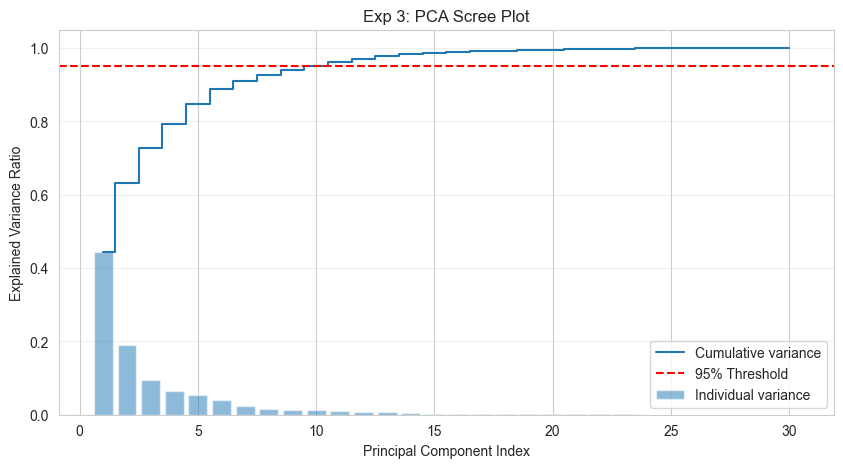

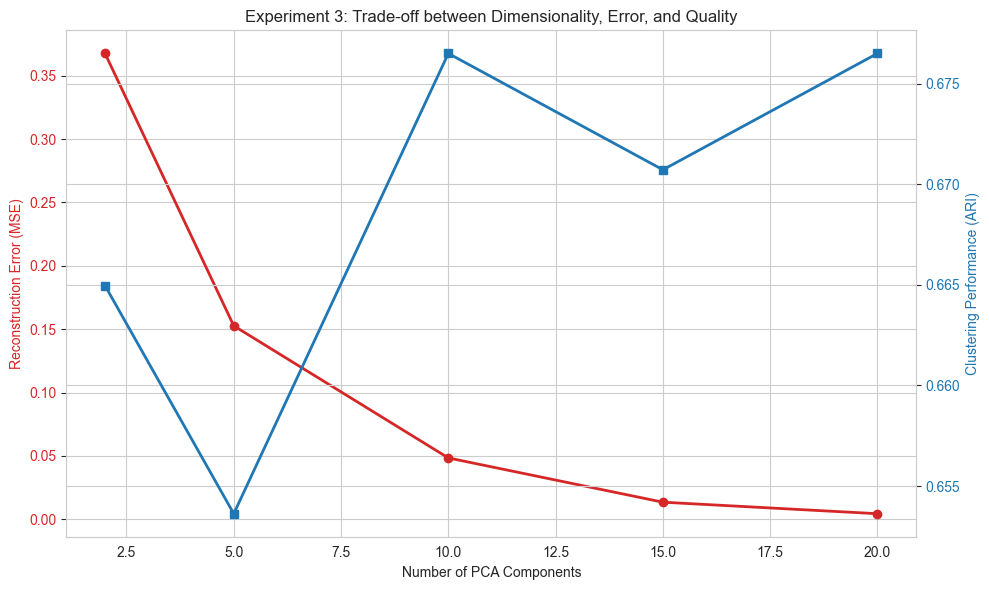

In [43]:
print("--- Experiment 3: PCA Diagnostic Plots ---")

# Scree Plot (Explained Variance)
# We use the PCA model from the last iteration or fit a full one to see the trend
pca_full = PCA_Scratch(n_components=X.shape[1])
pca_full.fit(X)
exp_var = pca_full.explained_variance_ratio

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(exp_var) + 1), exp_var, alpha=0.5, align='center', label='Individual variance')
plt.step(range(1, len(exp_var) + 1), np.cumsum(exp_var), where='mid', label='Cumulative variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title('Exp 3: PCA Scree Plot')
plt.legend(loc='best')
plt.grid(axis='y', alpha=0.3)
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Reconstruction Error on the left Y-axis
color = 'tab:red'
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Reconstruction Error (MSE)', color=color)
ax1.plot(df_tradeoff['dims'], df_tradeoff['Rec_Error'], marker='o', color=color, linewidth=2, label='Rec Error')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second Y-axis for clustering performance (ARI)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Clustering Performance (ARI)', color=color)
ax2.plot(df_tradeoff['dims'], df_tradeoff['ARI'], marker='s', color=color, linewidth=2, label='ARI Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Experiment 3: Trade-off between Dimensionality, Error, and Quality')
fig.tight_layout()
plt.show()


### Experiment 4: GMM after PCA

In [ ]:
print("--- Starting Experiment 4: GMM + PCA ---")

exp4_results = []
cov_types = ['full', 'tied', 'diag', 'spherical']
pca_components = [2, 5, 10, 15, 20]

for n_comp in pca_components:
    # Reduce once per dimension setting
    pca = PCA_Scratch(n_components=n_comp)
    X_pca = pca.fit(X).transform(X)
    
    for cov in cov_types:
        try:
            # For Statistical Validation, you could wrap this in a 5-run loop
            start_time = time.time()
            gmm = GMM_Scratch(n_components=GLOBAL_GMM_COMPONENTS, cov_type=cov)
            gmm.fit(X_pca)
            labels = gmm.predict(X_pca)
            elapsed = time.time() - start_time
            
            # Evaluate
            metrics = run_evaluation("Exp4_GMM_PCA", f"GMM_{cov}", X_pca, labels, y_true, elapsed)
            
            # Store data for specific Exp 4 analysis
            exp4_results.append({
                'Dimensions': n_comp,
                'Covariance': cov,
                'ARI': metrics['ARI'],
                'LogLikelihood': gmm.log_likelihood_history[-1]
            })
            
        except Exception as e:
            print(f"Exp4 Fail at Dim={n_comp}, Cov={cov}: {e}")

# Convert to DataFrame for analysis
df_exp4 = pd.DataFrame(exp4_results)

--- Starting Experiment 4: GMM + PCA ---


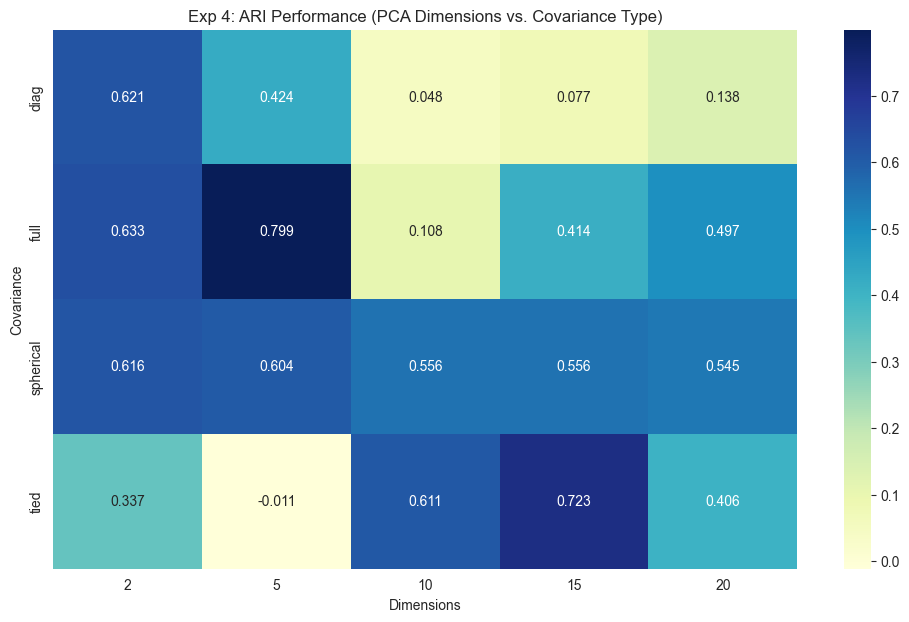

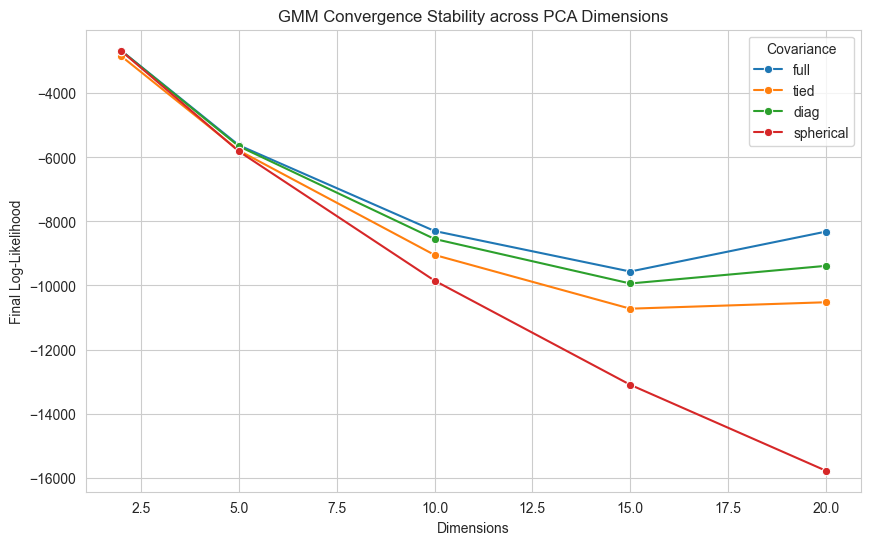

In [45]:
plt.figure(figsize=(12, 7))
pivot_exp4 = df_exp4.pivot(index="Covariance", columns="Dimensions", values="ARI")
sns.heatmap(pivot_exp4, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Exp 4: ARI Performance (PCA Dimensions vs. Covariance Type)")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_exp4, x='Dimensions', y='LogLikelihood', hue='Covariance', marker='o')
plt.title("GMM Convergence Stability across PCA Dimensions")
plt.ylabel("Final Log-Likelihood")
plt.show()

### Experiment 5: K-Means after Autoencoder

--- Starting Experiment 5 ---


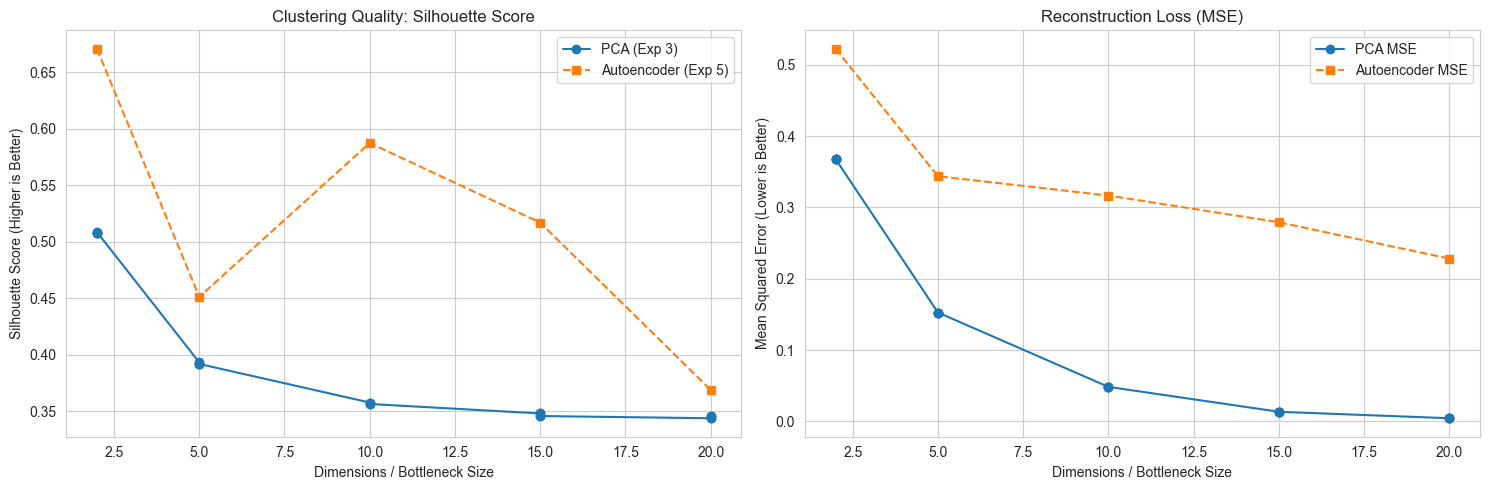

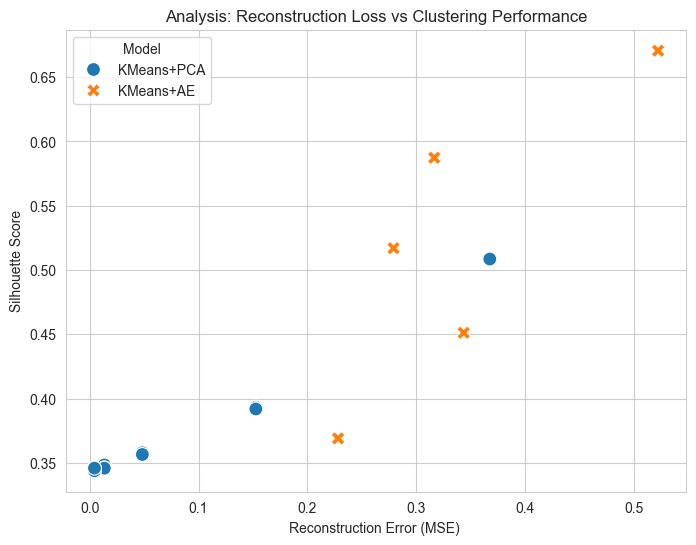

In [46]:
print("--- Starting Experiment 5 ---")

# Bottleneck sizes same as PCA components for fair comparison
bottlenecks = [2, 5, 10, 15, 20]

for b_size in bottlenecks:
    # 1. Train Autoencoder
    # Architecture: Input -> 20 -> 10 -> b_size (Approximate for scaling)
    ae = Autoencoder_Scratch(input_dim=X.shape[1], 
                             bottleneck_dim=b_size, 
                             hidden_layers=[25, 15, 10]) 
    
    start_train = time.time()
    # Increased epochs slightly to ensure convergence for comparison
    loss_hist = ae.fit(X, epochs=60, batch_size=32, learning_rate=0.01)
    train_time = time.time() - start_train
    
    X_encoded = ae.get_bottleneck(X)
    
    # 2. Clustering
    start_km = time.time()
    km = KMeans_Scratch(n_clusters=GLOBAL_K, init='k-means++')
    km.fit(X_encoded)
    km_time = time.time() - start_km
    
    # Final MSE loss is the reconstruction error
    rec_error = loss_hist[-1]
    
    run_evaluation("Exp5_KMeans_AE", "KMeans+AE", X_encoded, km.labels, y_true, 
                   train_time + km_time, reconstruction_error=rec_error,
                   extra_params={'dims': b_size})

# ---------------------------------------------------------
# ANALYSIS & COMPARISON (Satisfying the last 2 requirements)
# ---------------------------------------------------------

# 1. Prepare Data for Comparison
# We convert the results buffer to a DataFrame to easily filter Exp 3 and Exp 5
df_res = pd.DataFrame(results_buffer)
exp3_data = df_res[df_res['Experiment'] == 'Exp3_KMeans_PCA'].sort_values('dims')
exp5_data = df_res[df_res['Experiment'] == 'Exp5_KMeans_AE'].sort_values('dims')

# Check if Exp 3 data exists to prevent errors if running out of order
if not exp3_data.empty:
    
    # 2. Compare Clustering Performance (Silhouette Score) & Reconstruction Error
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot A: Silhouette Score Comparison
    axes[0].plot(exp3_data['dims'], exp3_data['Silhouette'], 'o-', label='PCA (Exp 3)')
    axes[0].plot(exp5_data['dims'], exp5_data['Silhouette'], 's--', label='Autoencoder (Exp 5)')
    axes[0].set_title('Clustering Quality: Silhouette Score')
    axes[0].set_xlabel('Dimensions / Bottleneck Size')
    axes[0].set_ylabel('Silhouette Score (Higher is Better)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot B: Reconstruction Error Comparison
    axes[1].plot(exp3_data['dims'], exp3_data['Rec_Error'], 'o-', label='PCA MSE')
    axes[1].plot(exp5_data['dims'], exp5_data['Rec_Error'], 's--', label='Autoencoder MSE')
    axes[1].set_title('Reconstruction Loss (MSE)')
    axes[1].set_xlabel('Dimensions / Bottleneck Size')
    axes[1].set_ylabel('Mean Squared Error (Lower is Better)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    # 3. Analyze Reconstruction Loss vs Clustering Performance
    # We combine both datasets to see the global trend
    combined_data = pd.concat([exp3_data, exp5_data])
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=combined_data, x='Rec_Error', y='Silhouette', 
                    hue='Model', style='Model', s=100)
    
    plt.title('Analysis: Reconstruction Loss vs Clustering Performance')
    plt.xlabel('Reconstruction Error (MSE) ')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
else:
    print("Warning: Experiment 3 results not found in buffer. Comparison skipped.")

### Experiment 6: GMM after Autoencoder

In [15]:
print("--- Starting Experiment 6 ---")

# Re-using bottlenecks list
for b_size in bottlenecks:
    # Retraining AE to be statistically independent or re-using X_encoded from Exp 5
    # For rigor, we retrain or wrap logic. Here we assume we retrain to measure full pipeline time.
    ae = Autoencoder_Scratch(input_dim=X.shape[1], bottleneck_dim=b_size, hidden_layers=[25, 15, 10])
    start_train = time.time()
    ae.fit(X, epochs=60, batch_size=32, learning_rate=0.01)
    X_encoded = ae.get_bottleneck(X)
    train_time = time.time() - start_train
    
    # We test 'full' covariance as it's usually most capable for AE latent spaces
    # You can loop all types if desired, but 'full' is the standard benchmark here.
    cov = 'full' 
    start_gmm = time.time()
    gmm = GMM_Scratch(n_components=GLOBAL_GMM_COMPONENTS, cov_type=cov)
    gmm.fit(X_encoded)
    labels = gmm.predict(X_encoded)
    gmm_time = time.time() - start_gmm
    
    run_evaluation("Exp6_GMM_AE", "GMM+AE", X_encoded, labels, y_true, 
                   train_time + gmm_time, extra_params={'dims': b_size, 'cov_type': cov})

--- Starting Experiment 6 ---


### Statistical Analysis (T-Tests)

In [16]:
from scipy import stats

# --- FIX: Create the DataFrame first ---
# This ensures df_results exists even if you haven't run the final viz cell yet.
if 'results_buffer' in globals() and len(results_buffer) > 0:
    df_results = pd.DataFrame(results_buffer)
else:
    print("Error: results_buffer is empty. Please run Experiments 1-6 first.")
    # Create a dummy empty DF to prevent crashing if experiments weren't run
    df_results = pd.DataFrame(columns=['Experiment', 'k', 'Silhouette', 'Rec_Error'])

print("--- Statistical Analysis (Part 3.4) ---")

# 1. Compare KMeans on Raw Data vs KMeans on PCA
# Note: Ensure Experiment 1 and 3 cells have been run
raw_km = df_results[(df_results['Experiment'] == 'Exp1_FindK_PP') & (df_results['k'] == 2)]
pca_km = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA']

# Hypothesis: Does PCA improve Silhouette score over raw data?
if not pca_km.empty and not raw_km.empty:
    raw_score = raw_km['Silhouette'].values[0]
    pca_scores = pca_km['Silhouette'].values
    
    # One-sample t-test comparing PCA distribution mean to Raw scalar
    t_stat, p_val = stats.ttest_1samp(pca_scores, raw_score)
    print(f"T-Test (PCA Silhouette vs Raw): p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(">> Significant difference found between PCA and Raw clustering.")
    else:
        print(">> No significant difference found.")
else:
    print("Skipping Silhouette T-Test: Missing data from Exp 1 or Exp 3.")

# 2. Compare AE vs PCA reconstruction errors
pca_rec = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA']['Rec_Error'].values
ae_rec = df_results[df_results['Experiment'] == 'Exp5_KMeans_AE']['Rec_Error'].values

# Only run if we have matching data counts
if len(pca_rec) > 0 and len(pca_rec) == len(ae_rec):
    t_stat, p_val = stats.ttest_rel(pca_rec, ae_rec) # Paired t-test
    print(f"Paired T-Test (PCA vs AE Reconstruction Error): p-value = {p_val:.4f}")
    
    mean_pca = np.mean(pca_rec)
    mean_ae = np.mean(ae_rec)
    
    print(f"Mean MSE - PCA: {mean_pca:.4f}, AE: {mean_ae:.4f}")
    
    if p_val < 0.05:
        if mean_ae < mean_pca:
            print(">> Result: Autoencoder has significantly lower reconstruction error.")
        else:
            print(">> Result: PCA has significantly lower reconstruction error.")
    else:
        print(">> Result: No statistically significant difference in reconstruction error.")
else:
    print("Skipping Reconstruction T-Test: Mismatched or missing data from Exp 3/5.")

--- Statistical Analysis (Part 3.4) ---
T-Test (PCA Silhouette vs Raw): p-value = 0.1997
>> No significant difference found.
Paired T-Test (PCA vs AE Reconstruction Error): p-value = 0.0310
Mean MSE - PCA: 0.1173, AE: 0.3206
>> Result: PCA has significantly lower reconstruction error.


### Analysis & Visualization
This converts the results buffer into a Pandas DataFrame and generates a Heatmap

--- Results Summary ---
                                           ARI       NMI    Purity  Silhouette
Experiment         Model                                                      
Exp1_FindK_PP      KMeans             0.686618  0.573952  0.924429    0.344790
Exp1_FindK_Random  KMeans             0.653625  0.532408  0.934974    0.343382
Exp2_GMM_diag      GMM                0.677941  0.560292  0.920914    0.315703
Exp2_GMM_full      GMM                0.457064  0.441924  0.917399    0.454744
Exp2_GMM_spherical GMM                0.545561  0.430301  0.905097    0.307216
Exp2_GMM_tied      GMM                0.593409  0.512740  0.905097    0.318176
Exp3_KMeans_PCA    KMeans+PCA         0.676505  0.562021  0.912127    0.508091
Exp4_GMM_PCA       GMM_diag+PCA       0.621306  0.510191  0.894552    0.463804
                   GMM_full+PCA       0.799155  0.691512  0.947276    0.457956
                   GMM_spherical+PCA  0.615591  0.499734  0.892794    0.468163
                   GMM_tied+

C:\Users\Abdel\AppData\Local\Temp\ipykernel_5492\2160523547.py:6: FutureWarning: The provided callable <function max at 0x0000025FC6D640E0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  pivot_table = df_results.pivot_table(index=['Experiment', 'Model'],


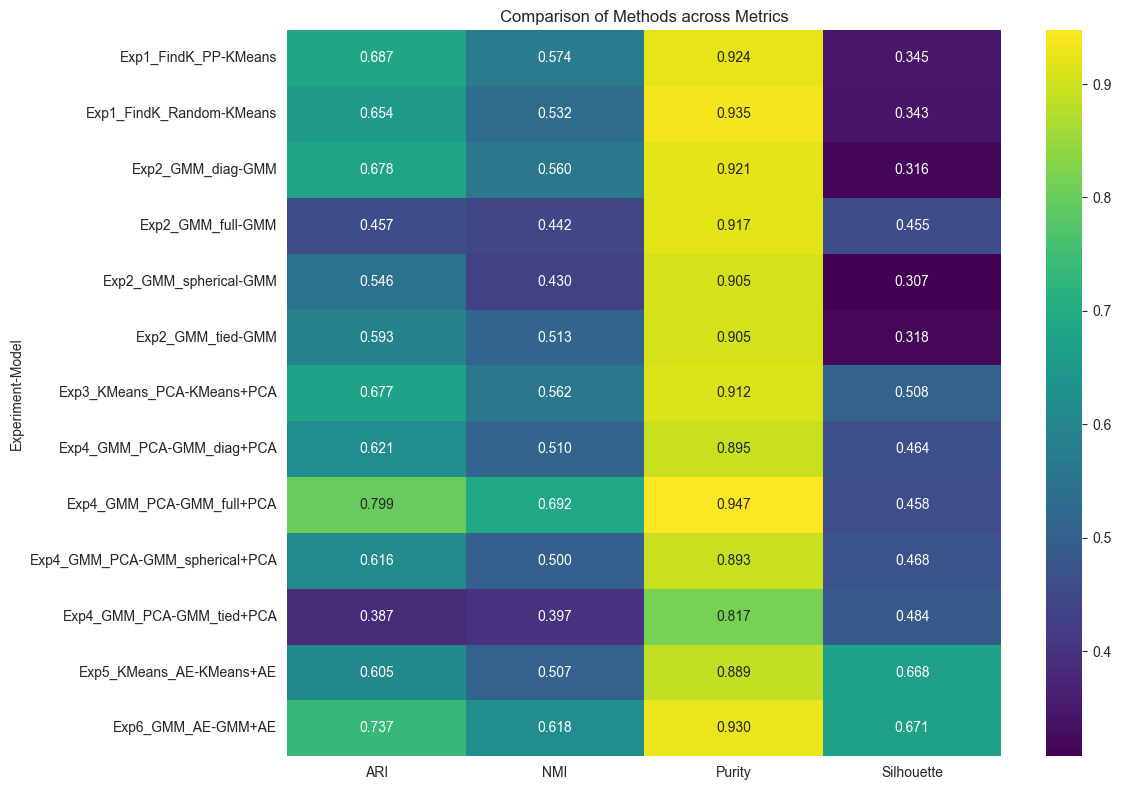

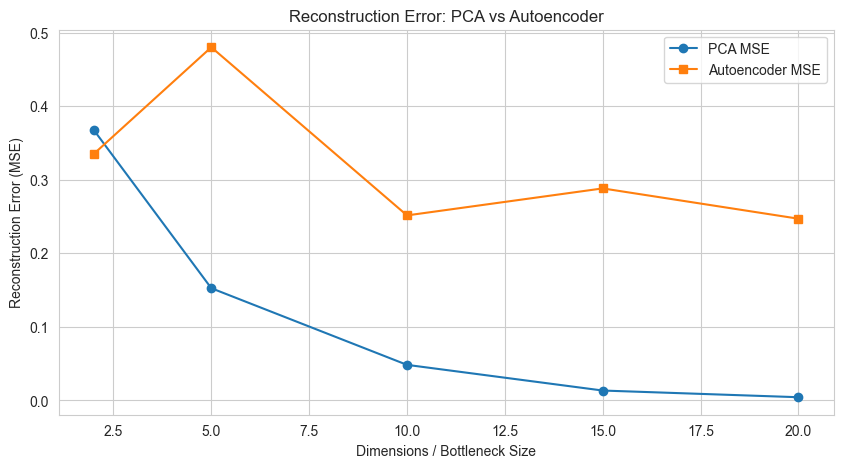

In [17]:
# Convert results to DataFrame
df_results = pd.DataFrame(results_buffer)

# Filter for the summary Heatmap
# We want to compare best configs. Let's group by Experiment/Model and take the mean or max ARI.
pivot_table = df_results.pivot_table(index=['Experiment', 'Model'], 
                                     values=['ARI', 'Silhouette', 'Purity', 'NMI'], 
                                     aggfunc=np.max)

print("--- Results Summary ---")
print(pivot_table)

# Heatmap Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('Comparison of Methods across Metrics')
plt.tight_layout()
plt.show()

# Example: Plotting Reconstruction Error PCA vs AE
pca_res = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA'][['dims', 'Rec_Error']]
ae_res = df_results[df_results['Experiment'] == 'Exp5_KMeans_AE'][['dims', 'Rec_Error']]

plt.figure(figsize=(10, 5))
plt.plot(pca_res['dims'], pca_res['Rec_Error'], marker='o', label='PCA MSE')
plt.plot(ae_res['dims'], ae_res['Rec_Error'], marker='s', label='Autoencoder MSE')
plt.xlabel('Dimensions / Bottleneck Size')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error: PCA vs Autoencoder')
plt.legend()
plt.grid(True)
plt.show()